In [19]:
import sys

import tensorflow.keras
import pandas as pd

import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.4.0
Keras Version: 2.4.0

Python 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 15:50:08) [MSC v.1916 64 bit (AMD64)]
Pandas 1.2.3
GPU is available


In [20]:
import sys
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Layer
from tensorflow.keras.layers import Dense, Dropout,Flatten, Reshape, Activation
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization, Input, LeakyReLU, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.compat.v1 as tf
from tqdm import tqdm

In [21]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro M620, pci bus id: 0000:01:00.0, compute capability: 5.0



In [22]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi('{"username":"kevalbotadra","key":"e5a5e4bf79e438e2b2b8e3a8a87d1c59"}')
api.authenticate()

In [23]:
api.dataset_download_files("soumikrakshit/anime-faces")

In [24]:
from zipfile import ZipFile
zipf = ZipFile('anime-faces.zip')
zipf.extractall()

In [25]:
image_cols = 64
image_rows = 64
image_channels = 3
image_shape = (image_cols, image_rows, image_channels)

In [8]:
class DataPreprocesser():
    def __init__(self):
        self.path = "data"
        path = "data"
        print("Preprocessing Data Now:")
    def create_data(self, face_data="data"):
        anime_faces = []
        
        for face in tqdm(os.listdir(face_data)):
            anime_face = cv2.imread(os.path.join(face_data,face))
            if anime_face is not None:
                anime_face = cv2.resize(anime_face, (image_cols, image_rows))
                anime_face = cv2.cvtColor(anime_face, cv2.COLOR_BGR2RGB)
                anime_faces.append(anime_face)
        anime_faces = np.array(anime_faces)
        return anime_faces

    def normalize_data(self, face_data="data"):
        X_train = self.create_data(face_data)
        X_train = X_train / 256
        return X_train

In [9]:
data_preprocess = DataPreprocesser()
images = data_preprocess.normalize_data()

  0%|                                                                              | 13/21552 [00:00<02:46, 129.06it/s]

Preprocessing Data Now:


100%|███████████████████████████████████████████████████████████████████████████| 21552/21552 [01:47<00:00, 200.07it/s]


In [10]:
from PIL import Image
from matplotlib.pyplot import imshow
def show_images(r):
    r = r * 256
    fig,ax = plt.subplots(3,3, figsize = (8,8)) 
    for i in range(3):
        for j in range(3):
            idx = 4 * i + j
            ax[i,j].imshow(r[idx])
            ax[i,j].axis('off')
    # fig.save(f"images/{epoch}.png")

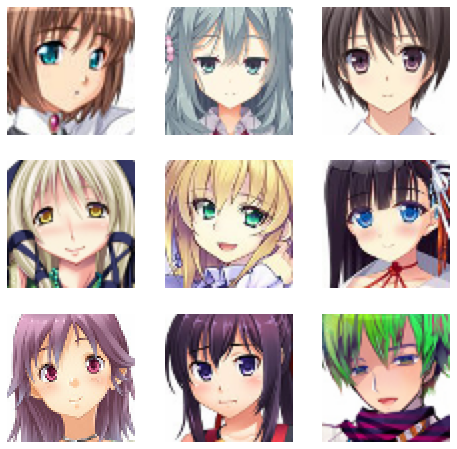

In [18]:
import random
rand_images = random.sample(list(images), 1000)
show_images(rand_images)

In [12]:
class Sampling(Layer):
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        return mean + tf.exp(0.5 * log_var) * epsilon

In [13]:
class VAE(keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = 2
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
    def build_encoder(self, latent_dim=None):
        if latent_dim == None:
            latent_dim = self.latent_dim
            
        encoder_inputs = (Input(shape=(64, 64, 3)))
        x = (BatchNormalization()(encoder_inputs))
        x = (Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x))
        x = (Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x))
#         x = (LeakyReLU(alpha=0.2)(x))
        x = (BatchNormalization()(x))
        x = (MaxPooling2D(2,2)(x))
        x =(Dropout(0.25)(x))

        x = (Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x))
        x = (Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x))
#         x = (LeakyReLU(alpha=0.2)(x))
        x = (BatchNormalization()(x))
        x = (MaxPooling2D(2,2)(x))
        x = (Dropout(0.25)(x))

        x = (Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x))
        x = (Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x))
#         x = (LeakyReLU(alpha=0.2)(x))
        x = (BatchNormalization()(x))
        x = (MaxPooling2D(2, 2)(x))
        x = (Dropout(0.25)(x))

        x = (Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x))
        x = (Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x))
#         x = (LeakyReLU(alpha=0.2)(x))
        x = (BatchNormalization()(x))
        x = (MaxPooling2D(2,2)(x))
        x = (Dropout(0.25)(x))


        x = (Flatten()(x))

        x = (Dense(128)(x))
        x = (Dropout(0.3)(x))
        x = (BatchNormalization()(x))

        x = (Dense(64)(x))
        x = (Dropout(0.2)(x))
        x = (BatchNormalization()(x))

        mean = (Dense(latent_dim, name="z_mean")(x))
        log_var = (Dense(latent_dim, name="z_log_var")(x))
        z = Sampling()([mean, log_var])
        encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")
        encoder.summary()
        
        return encoder

        
    def build_decoder(self, latent_dim=None):
        if latent_dim == None:
            latent_dim = self.latent_dim
            
        latent_inputs = (Input(shape=(latent_dim,)))
        x = (Dense(64*4*4, use_bias=False)(latent_inputs))
        x = (BatchNormalization()(x))
#         x = (LeakyReLU()(x))
        x = (Reshape((4, 4, 64))(x))

        x = (Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation="relu")(x))
        x = (BatchNormalization()(x))
        x = (LeakyReLU()(x))
        x = (Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation="relu")(x))

        x = (BatchNormalization()(x))
        x = (LeakyReLU()(x))
        x = (Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation="relu")(x))

        x = (BatchNormalization()(x))
        x = (LeakyReLU()(x))
        decoder_outputs = (Conv2DTranspose(3, (3, 3), strides=(4, 4), padding='same', use_bias=False, activation='sigmoid')(x))
        decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
        decoder.summary()
        
        return decoder
    
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            mean, log_var, z = self.encoder(data)
            recon = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, recon), axis=(1, 2)))
            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            loss = recon_loss + kl_loss
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

        
    
    

In [14]:
X_train = data_preprocess.normalize_data()

100%|██████████████████████████████████████████████████████████████████████████| 21552/21552 [00:08<00:00, 2568.19it/s]


In [15]:
vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam())


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   1792        batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       conv2d[0][0]                     
____________________________________________________________________________________________

In [16]:
vae.fit(X_train, epochs=30, batch_size=64)

Epoch 1/30
337/337 [==============================] - 113s 295ms/step - loss: 2692.7051 - reconstruction_loss: 0.0000e+00 - kl_loss: 4.6491
Epoch 2/30
337/337 [==============================] - 94s 279ms/step - loss: 2569.6184 - reconstruction_loss: 0.0000e+00 - kl_loss: 4.7286
Epoch 3/30
337/337 [==============================] - 96s 284ms/step - loss: 2568.6087 - reconstruction_loss: 0.0000e+00 - kl_loss: 4.6224
Epoch 4/30
337/337 [==============================] - 98s 289ms/step - loss: 2564.8092 - reconstruction_loss: 0.0000e+00 - kl_loss: 4.7627
Epoch 5/30
337/337 [==============================] - 98s 291ms/step - loss: 2565.0460 - reconstruction_loss: 0.0000e+00 - kl_loss: 4.7958
Epoch 6/30
337/337 [==============================] - 88s 260ms/step - loss: 2562.9170 - reconstruction_loss: 0.0000e+00 - kl_loss: 4.7995
Epoch 7/30
337/337 [==============================] - 87s 259ms/step - loss: 2561.5135 - reconstruction_loss: 0.0000e+00 - kl_loss: 4.8748
Epoch 8/30
337/337 [======

In [ ]:
vae.save("models/anime_vae")